# DINOv2 Exploration

This notebook is used for exploring the DINOv2 model, including loading the model, running predictions, and visualizing results.

In [27]:
import os
os.chdir('/Users/mattiamartino/Desktop/X/year1/sem2/cv/adversarial-attack-diffusion/prompt_tuning_attack')
print("Current working directory:", os.getcwd())

from src.models.dinov2_model import Dinov2Model
from src.utils.visualization import display_image, open_image

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA


import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset


# Initialize the DINOv2 model
dinov2_model = Dinov2Model()
dinov2_model.load_model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dinov2_model.to(device)

Current working directory: /Users/mattiamartino/Desktop/X/year1/sem2/cv/adversarial-attack-diffusion/prompt_tuning_attack
Using device: cpu


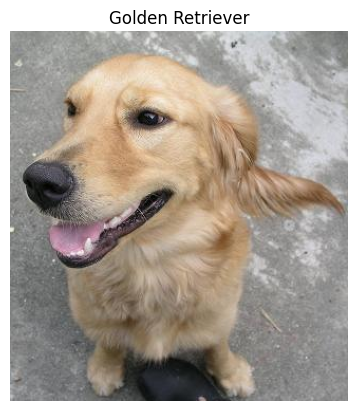

In [20]:
# Dispaly an image
input_image_path = 'dogs_data/Images/n02099601-golden_retriever/n02099601_6099.jpg'  # Use the already defined path
image = open_image(input_image_path)
display_image(image, title='Golden Retriever')

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='dogs_data/Images/', transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [15]:
dinov2_model.eval()

In [16]:
np.random.seed(42)

selected_indices = np.random.choice(len(dataset.classes), size=10, replace=False)
print([dataset.classes[i].split('-')[1:] for i in selected_indices])

[['Rottweiler'], ['Shih', 'Tzu'], ['Australian_terrier'], ['Airedale'], ['basset'], ['standard_schnauzer'], ['Brabancon_griffon'], ['Yorkshire_terrier'], ['Irish_water_spaniel'], ['beagle']]


In [26]:
target_indices = [i for i, (_, label) in enumerate(dataset) if label in selected_indices]

# Create a subset for the target breed
breed_subset = Subset(dataset, target_indices)

# Now you can create a DataLoader for this subset
dataloader = DataLoader(breed_subset, batch_size=256, shuffle=False)

In [7]:
# features = []
# labels = []
# for imgs, target in breed_loader:

#     imgs, target = imgs.to(device), target.to(device)

#     feats = dinov2_model.predict(imgs)

#     feats = feats[0].cpu()
#     features.append(feats)
#     labels.extend(target.cpu().numpy())

# features = torch.cat(features, dim=0)

In [8]:
# features_avg = features.mean(dim=1)

# normalized_features = F.normalize(features_avg, p=2, dim=1)

# n = normalized_features.shape[0]
# similarities = torch.mm(normalized_features, normalized_features.t())

# mask = ~torch.eye(n, dtype=bool, device=similarities.device)
# similarities_no_diagonal = similarities[mask]

# avg_similarity = similarities_no_diagonal.mean().item()
# print(f"Average cosine similarity between features: {avg_similarity:.4f}")

# plt.figure(figsize=(10, 6))
# sns.histplot(similarities_no_diagonal.cpu().numpy(), bins=50, kde=True)
# plt.title(f'Distribution of Cosine Similarities (Average: {avg_similarity:.4f})')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.axvline(x=avg_similarity, color='r', linestyle='--', label=f'Average: {avg_similarity:.2f}')
# plt.legend()
# plt.tight_layout()

In [28]:
features = []
labels = []
for imgs, target in tqdm(dataloader):

    imgs, target = imgs.to(device), target.to(device)

    feats = dinov2_model.predict(imgs)

    feats = feats[0].cpu()
    features.append(feats)
    labels.extend(target.cpu().numpy())

features = torch.cat(features, dim=0)

100%|██████████| 7/7 [01:09<00:00,  9.87s/it]


In [29]:
features_avg = features.mean(dim=1)

normalized_features = F.normalize(features_avg, p=2, dim=1)

n = normalized_features.shape[0]
similarities = torch.mm(normalized_features, normalized_features.t())

mask = ~torch.eye(n, dtype=bool, device=similarities.device)
similarities_no_diagonal = similarities[mask]

avg_similarity = similarities_no_diagonal.mean().item()
print(f"Average cosine similarity between features: {avg_similarity:.4f}")

Average cosine similarity between features: 0.3249


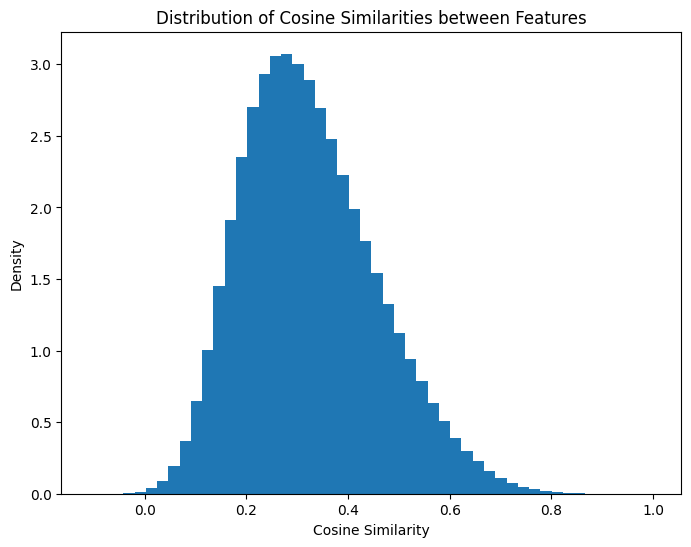

In [30]:
# Convert similarities tensor to a numpy array
similarities_np = similarities_no_diagonal.cpu().numpy()

# Plot histogram of similarities
plt.figure(figsize=(8, 6))
plt.hist(similarities_np, bins=50, density=True)
# plt.axvline(x=similarities_no_diagonal, color='r', linestyle='--', label=f'Average: {avg_similarity:.2f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Distribution of Cosine Similarities between Features')
plt.show()

In [31]:
# Convert features to numpy array
features_np = features_avg.numpy()
labels_np = np.array(labels)

# Get unique classes
unique_classes = np.unique(labels_np)
n_classes = len(unique_classes)

# Map class indices to class names
class_id_to_name = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [class_id_to_name[cls] for cls in unique_classes]

# Compute centroids for each class
centroids = np.zeros((n_classes, features_np.shape[1]))
for i, cls in enumerate(unique_classes):
    class_indices = np.where(labels_np == cls)[0]
    centroids[i] = np.mean(features_np[class_indices], axis=0)

# Calculate pairwise distances
cosine_dist = cosine_distances(centroids)
euclidean_dist = euclidean_distances(centroids)

# Create DataFrame for distances
# Create DataFrame for Euclidean distances
distance_df = pd.DataFrame(
    euclidean_dist,
    index=[name.split('-')[-1] for name in class_names],
    columns=[name.split('-')[-1] for name in class_names]
)

# Create DataFrame for Cosine distances
cosine_df = pd.DataFrame(
    cosine_dist,
    index=[name.split('-')[-1] for name in class_names],
    columns=[name.split('-')[-1] for name in class_names]
)

# Apply PCA for visualization
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)
explained_variance = pca.explained_variance_ratio_

# Create DataFrame for PCA results
pca_df = pd.DataFrame({
    'PC1': centroids_2d[:, 0],
    'PC2': centroids_2d[:, 1],
    'Breed': [name.split('--')[-1] for name in class_names]
})


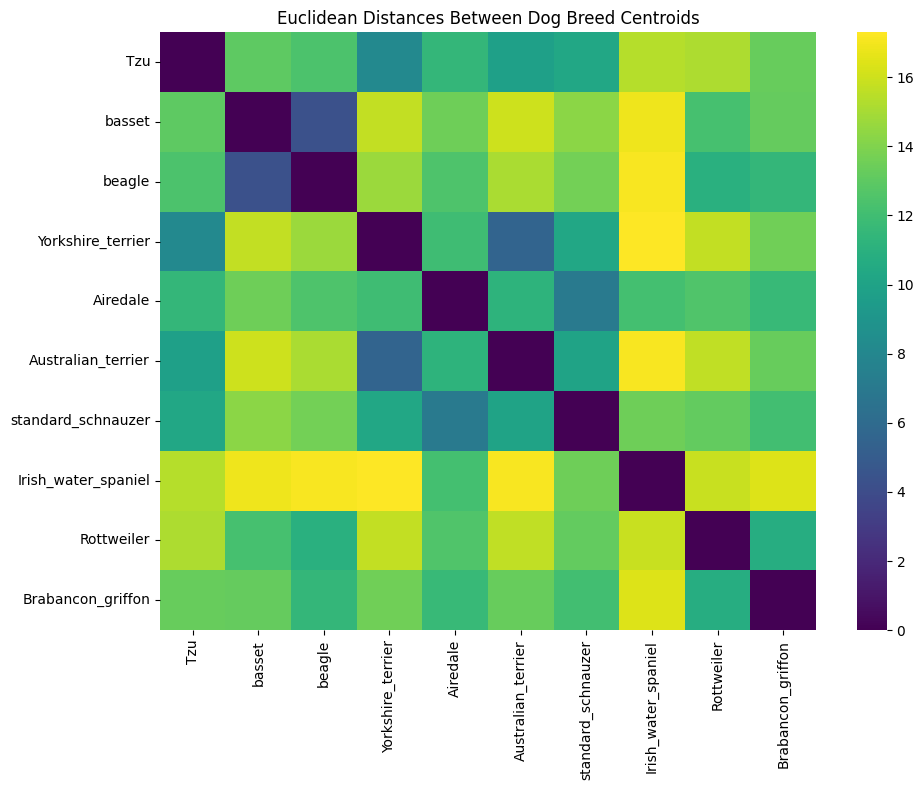

In [32]:
# Display heatmap with subset selection if needed
plt.figure(figsize=(10, 8))

sns.heatmap(distance_df, cmap='viridis')
plt.title('Euclidean Distances Between Dog Breed Centroids')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

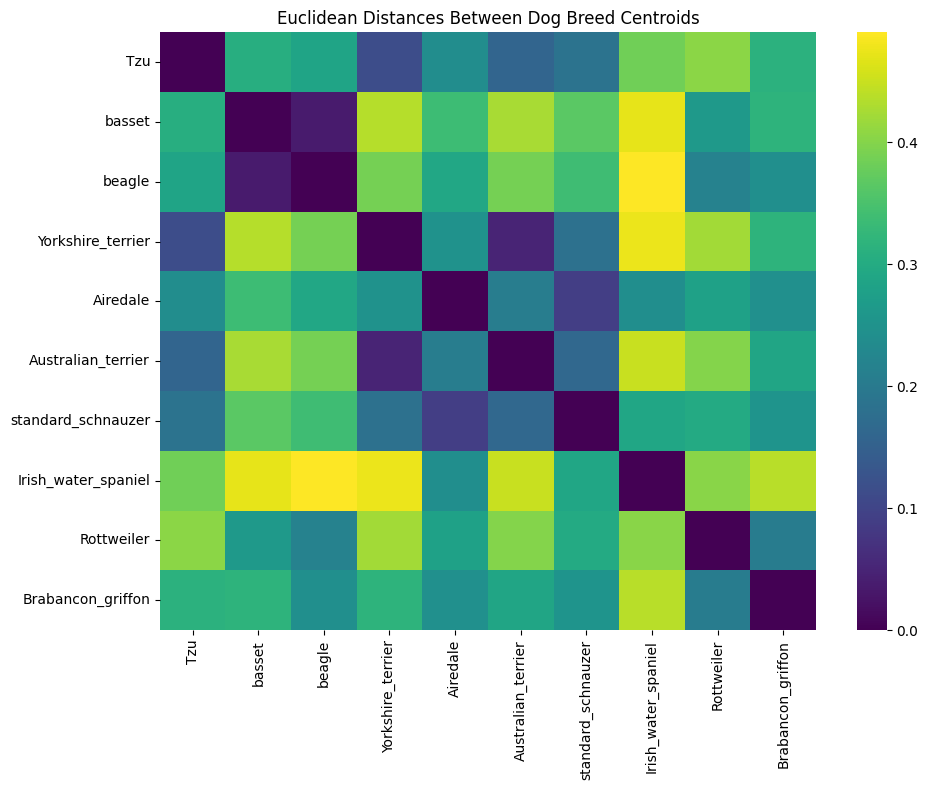

In [33]:
# Display heatmap with subset selection if needed
plt.figure(figsize=(10, 8))

sns.heatmap(cosine_df, cmap='viridis')
plt.title('Euclidean Distances Between Dog Breed Centroids')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [34]:
distance_df.values[np.tril_indices_from(distance_df)] = np.nan
cosine_df.values[np.tril_indices_from(cosine_df)] = np.nan

euclidean_long = distance_df.stack().reset_index()
euclidean_long.columns = ['Breed1', 'Breed2', 'Euclidean_Distance']

cosine_long = cosine_df.stack().reset_index()
cosine_long.columns = ['Breed1', 'Breed2', 'Cosine_Distance']

merged_distances = pd.merge(euclidean_long, cosine_long, on=['Breed1', 'Breed2'])

merged_distances = merged_distances.sort_values(by='Euclidean_Distance')

merged_distances.head(10)

,Breed1,Breed2,Euclidean_Distance,Cosine_Distance
9,basset,beagle,4.302022,0.034642
25,Yorkshire_terrier,Australian_terrier,5.527078,0.048372
31,Airedale,standard_schnauzer,7.081960,0.088979
2,Tzu,Yorkshire_terrier,8.122588,0.114089
4,Tzu,Australian_terrier,9.796605,0.157093
35,Australian_terrier,standard_schnauzer,10.043340,0.163324
5,Tzu,standard_schnauzer,10.295386,0.186510
26,Yorkshire_terrier,standard_schnauzer,10.311909,0.181169
44,Rottweiler,Brabancon_griffon,10.790621,0.203823
22,beagle,Rottweiler,10.981518,0.218108


In [43]:
merged_distances.tail(10)

,Breed1,Breed2,Euclidean_Distance,Cosine_Distance
37,Australian_terrier,Rottweiler,15.643154,0.398327
10,basset,Yorkshire_terrier,15.730874,0.434890
28,Yorkshire_terrier,Rottweiler,15.735263,0.421840
42,Irish_water_spaniel,Rottweiler,15.837515,0.402670
12,basset,Australian_terrier,15.959921,0.426384
43,Irish_water_spaniel,Brabancon_griffon,16.415255,0.437828
14,basset,Irish_water_spaniel,16.886854,0.470900
21,beagle,Irish_water_spaniel,17.094157,0.489956
36,Australian_terrier,Irish_water_spaniel,17.130095,0.448151
27,Yorkshire_terrier,Irish_water_spaniel,17.296692,0.475117


# Loss trials

In [90]:
random_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(30),
    #transforms.ToTensor()
])

In [72]:
pil_to_tensor = transforms.ToTensor()
tensor_to_pil = transforms.ToPILImage()

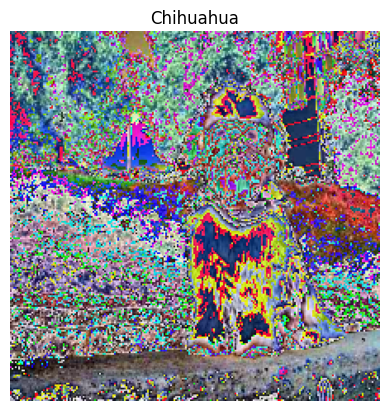

In [96]:
img, target = dataloader.dataset[0]
img = tensor_to_pil(img)
display_image(img, title=dataset.classes[0].split('-')[-1])

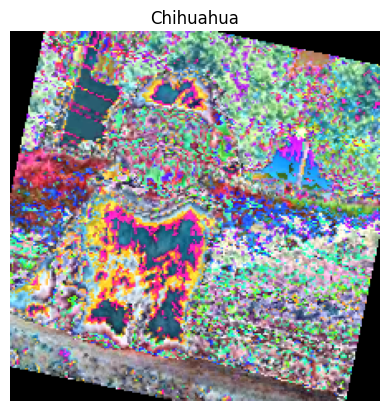

In [97]:
transformed_img = random_transform(img)
display_image(transformed_img, title=dataset.classes[0].split('-')[-1])

In [ ]:
original_features = dinov2_model.predict(pil_to_tensor(img).unsqueeze(0).to(device))[0].cpu()
original_features = original_features.mean(dim=1)
norm_original_features = original_features / torch.norm(original_features, dim=1, keepdim=True)

transformed_features = dinov2_model.predict(pil_to_tensor(transformed_img).unsqueeze(0).to(device))[0].cpu()
transformed_features = transformed_features.mean(dim=1)
norm_transformed_features = transformed_features / torch.norm(transformed_features, dim=1, keepdim=True)

In [108]:
cosine_sim = F.cosine_similarity(norm_original_features, norm_transformed_features)
print(f"Cosine Similarity between original and transformed images: {cosine_sim.item():.4f}")

euclidean_dist = F.pairwise_distance(original_features, transformed_features)
print(f"Euclidean Distance between original and transformed images: {euclidean_dist.item():.4f}")

Cosine Similarity between original and transformed images: 0.6207
Euclidean Distance between original and transformed images: 25.1316


In [ ]:
features_original = []
features_transformed = []
labels = []

for imgs, target in tqdm(dataloader):
    imgs, target = imgs.to(device), target.to(device)

    # Get the representation for the original images.
    feats_orig = dinov2_model.predict(imgs)[0].cpu()
    
    # Apply random transformation to each image in the batch.
    # Note: if imgs is a tensor, you might need to apply the transform to each image individually.
    transformed_imgs = torch.stack([random_transform(img.cpu()) for img in imgs])
    transformed_imgs = transformed_imgs.to(device)
    
    # Get the representation for the transformed images.
    feats_trans = dinov2_model.predict(transformed_imgs)[0].cpu()

    features_original.append(feats_orig)
    features_transformed.append(feats_trans)
    labels.extend(target.cpu().numpy())

# Concatenate the batch features.
features_original = torch.cat(features_original, dim=0)
features_transformed = torch.cat(features_transformed, dim=0)

features_original = features_original.mean(dim=1)
features_transformed = features_transformed.mean(dim=1)

100%|██████████| 7/7 [02:13<00:00, 19.12s/it]


In [114]:
cosine_sim = F.cosine_similarity(features_original, features_transformed, dim=1)
avg_cosine_sim = cosine_sim.mean().item()
print("Average Cosine Similarity:", avg_cosine_sim)

Average Cosine Similarity: 0.4492311477661133


In [ ]:
euclidean_dist =  F.pairwise_distance(features_original, features_transformed)
avg_euclidean_dist = euclidean_dist.mean().item()
print("Average Euclidean Distance:", avg_euclidean_dist)

Average Euclidean Distance: 28.43109703063965
